In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import tensorflow as tf

In [2]:
#Read in data 112K rows
data = pd.read_csv('Data_Entry_2017.csv')
data.drop('Unnamed: 11',axis=1, inplace=True)
data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


In [3]:
#Add specific imagepath for correct diagnosis
images = {os.path.basename(x): x for x in 
                   glob(os.path.join('images*', '*', '*.png'))}
print('Scans found:', len(images), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(images.get)
data.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
42141,00010832_006.png,Consolidation,6,10832,61,F,AP,2500,2048,0.168,0.168,images_005/images/00010832_006.png
12562,00003284_000.png,Mass|Nodule,0,3284,68,M,PA,2500,2048,0.171,0.171,images_002/images/00003284_000.png
57178,00014197_028.png,Infiltration,28,14197,56,M,AP,3056,2544,0.139,0.139,images_007/images/00014197_028.png


In [4]:
#Drop ages over 120
data = data[data['Patient Age']<120]

In [5]:
# Diagnosis to predict
data['clean_labels'] = data['Finding Labels'].apply(lambda x: x.split('|'))
labels = data['clean_labels'].str.join('|').str.get_dummies()
data = data.join(labels)

/home/slindhult/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data['Finding Labels'].unique()

In [ ]:
data['View Position'].unique()

In [6]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

#all_labels = labels.columns
#clean_labels = []
#for i in all_labels:
#    j = data[i].sum()
#    if j >1000:
#        clean_labels.append((i,j))
#    else:
#        print(i)

#print(clean_labels)    
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>1000]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


In [7]:
data.drop('Hernia', axis=1, inplace=True)
labels.drop('Hernia', axis=1, inplace=True)

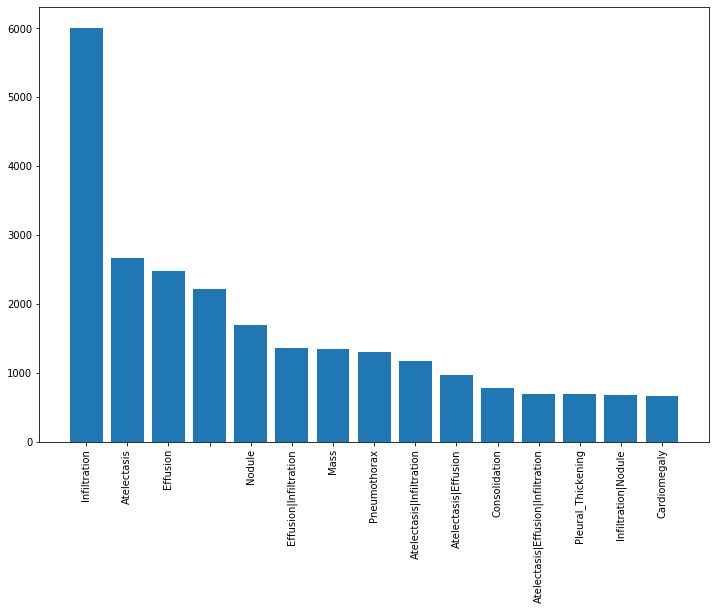

In [8]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)


label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [9]:
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [10]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.25, 
                                   random_state = 2018, 
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', test_df.shape[0])

train 30000 validation 10000


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size = (128, 128)
img_gen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [12]:
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

train_gen = img_gen.flow_from_dataframe(dataframe=train_df, directory=None, x_col = 'path',
y_col = 'newLabel', classmode = 'categorical',
classes = all_labels, targetsize = image_size, colormode = 'grayscale',
batch_size = 32)

test_gen = img_gen.flow_from_dataframe(dataframe=test_df, directory=None, x_col = 'path',
y_col = 'newLabel', classmode = 'categorical',
classes = all_labels, targetsize = image_size, colormode = 'grayscale',
batch_size = 256)

test_X, test_Y = next(img_gen.flow_from_dataframe(dataframe=test_df,
directory=None,
x_col = 'path', y_col = 'newLabel',
classmode = 'categorical', classes = all_labels,
targetsize = image_size,
colormode = 'grayscale', batchsize = 2048))


/home/slindhult/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/slindhult/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Found 28287 validated image filenames belonging to 13 classes.
Found 9431 validated image filenames belonging to 13 classes.
Found 9431 validated image filenames belonging to 13 classes.


In [ ]:
test_gen.filenames

Found 15 validated image filenames belonging to 13 classes.


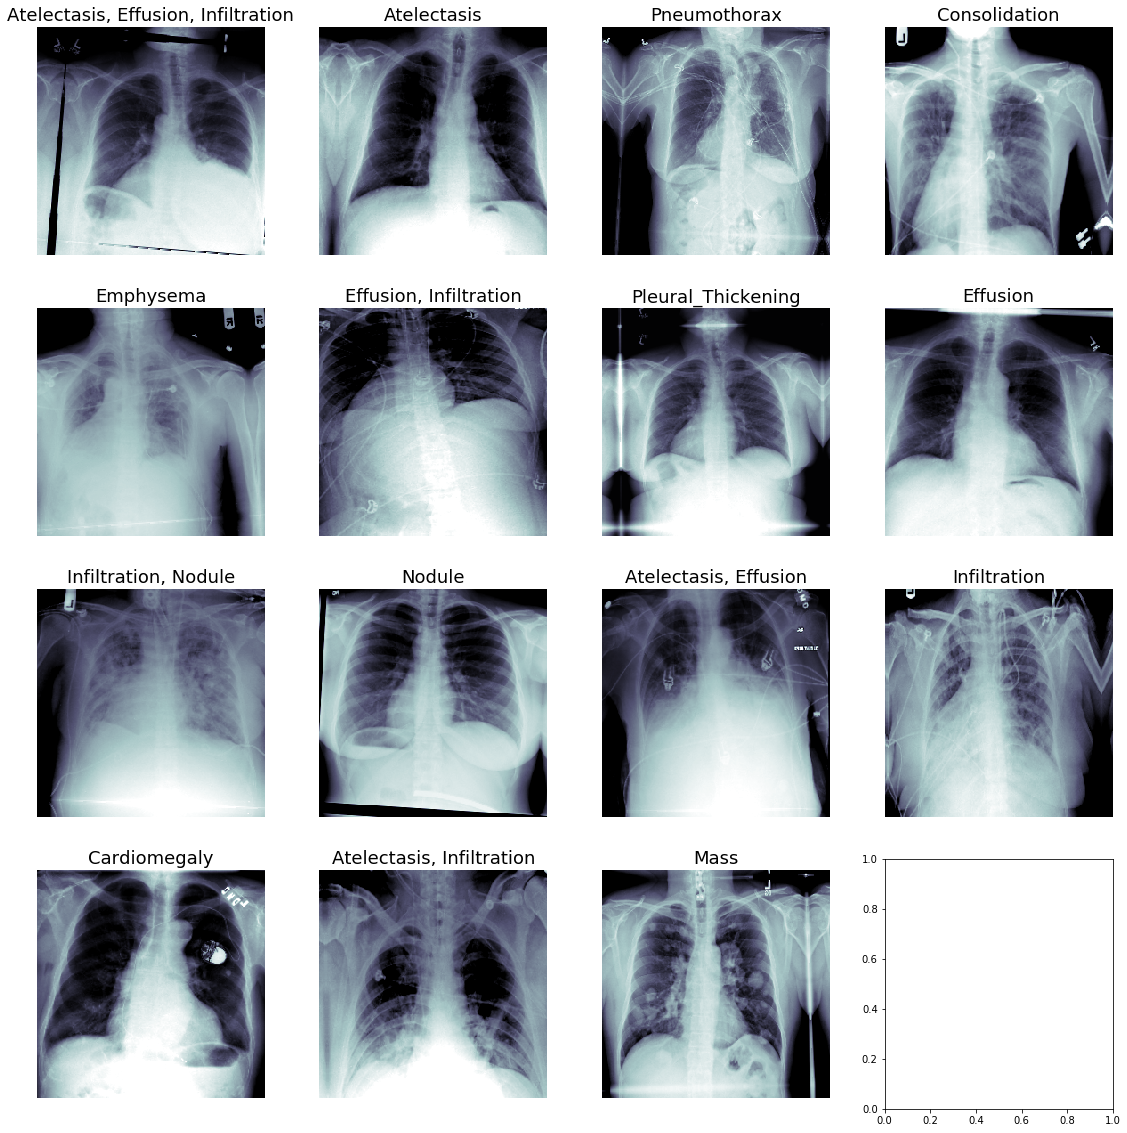

In [13]:
##show top 16 diagnosis
diags_list = data['Finding Labels'].value_counts().index[:16]
diag_img_list = []
for i in diags_list:
    k = data[data['Finding Labels'] == i].index[0]
    diag_img_list.append(k)

imgs = data.filter(diag_img_list, axis=0)
imgs['newLabel'] = imgs.apply(lambda x: x['Finding Labels'].split('|'), axis=1)


diag_gen = img_gen.flow_from_dataframe(dataframe=imgs, directory=None, x_col = 'path',
y_col = 'newLabel', classmode = 'categorical',
classes = all_labels, targetsize = image_size, colormode = 'grayscale',
batch_size = 32)

t_x, t_y = next(diag_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]), fontsize=18)
    c_ax.axis('off')
    
fig.tight_layout()
fig.savefig('figures/diagnoses.jpg')

In [14]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)

multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.build(input_shape=image_size)
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_256 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                6669      
Total params: 3,760,333
Trainable params: 3,738,445
Non-trainable params: 21,888
_________________________________________

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [16]:
multi_disease_model.fit(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

  ...
    to  
  ['...']
Train for 100 steps, validate on 32 samples
 99/100 [============================>.] - ETA: 4s - loss: 0.4223 - binary_accuracy: 0.8477 - mae: 0.2075
Epoch 00001: val_loss improved from inf to 0.35503, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 478s 5s/step - loss: 0.4220 - binary_accuracy: 0.8477 - mae: 0.2076 - val_loss: 0.3550 - val_binary_accuracy: 0.8702 - val_mae: 0.1966


In [17]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 31.25%
Cardiomegaly: 9.38%
Consolidation: 12.50%
Edema: 0.00%
Effusion: 31.25%
Emphysema: 9.38%
Fibrosis: 3.12%
Infiltration: 31.25%
Mass: 6.25%
Nodule: 15.62%
Pleural_Thickening: 6.25%
Pneumonia: 0.00%
Pneumothorax: 12.50%


In [18]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 256, verbose = True)

32/32 [==============================] - 1s 38ms/sample


/home/slindhult/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/slindhult/anaconda3/envs/test_env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


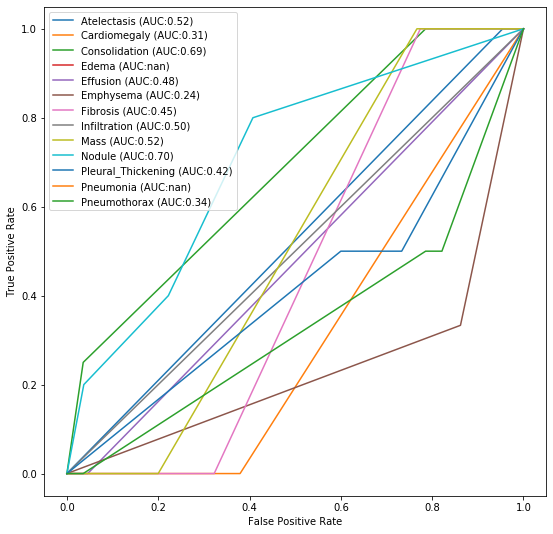

In [19]:
#a = np.stack(test_df['disease_vec'].values)
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
test_df

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 100 steps, validate on 32 samples
Epoch 1/5
 99/100 [============================>.] - ETA: 4s - loss: 0.3683 - binary_accuracy: 0.8599 - mae: 0.2083
Epoch 00001: val_loss did not improve from 0.35503
100/100 [==============================] - 493s 5s/step - loss: 0.3682 - binary_accuracy: 0.8599 - mae: 0.2083 - val_loss: 0.4011 - val_binary_accuracy: 0.8702 - val_mae: 0.1652
Epoch 2/5
 99/100 [============================>.] - ETA: 5s - loss: 0.3518 - binary_accuracy: 0.8640 - mae: 0.2039 
Epoch 00002: val_loss did not improve from 0.35503
100/100 [==============================] - 537s 5s/step - loss: 0.3515 - binary_accuracy: 0.8641 - mae: 0.2039 - val_loss: 0.4397 - val_binary_accuracy: 0.8702 - val_mae: 0.1541
Epoch 3/5
 96/100 [===========================>..] - ETA: 24s - loss: 0.3517 - binary_accuracy: 0.8652 - mae: 0.2057

In [ ]:
multi_disease_model.load_weights(weight_path)
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

In [ ]:
pred_Y = multi_disease_model.predict_generator(test_gen, verbose = True)

        


In [ ]:
valids = [i[-16:] for i in test_gen.filenames]
invalids = []
for i, j in zip(list(test_df['Image Index']), test_df['Image Index'].index):
    if i not in valids:
        invalids.append(j)

for i in invalids:
    test_df.drop(index=i, inplace=True)

In [ ]:
test_df['predictions'] = list(pred_Y)
test_df['cad'] = test_df['predictions'].apply(lambda x: x.argsort()[-3:][::-1])
test_df['cad diagnosis'] = test_df['cad'].apply(lambda x: f'{all_labels[x[0]]} ,{all_labels[x[1]]}  , {all_labels[x[2]]}')
test_df['cad likelihoods'] = test_df['predictions'].apply(lambda x: sorted(x, reverse=True)[:3])

In [ ]:
test_df['cad diagnosis'].unique()

In [ ]:
test_df

In [ ]:
a = np.stack(test_df['disease_vec'].values)
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, pathology) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(a[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (pathology, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
multi_disease_model.load_weights(weight_path)
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
test_df

In [ ]:
test_X[2]

In [ ]:
plt.imshow(test_X[0])

In [ ]:
plt.imshow(test_X[0][:,:,0], cmap='bone')

In [ ]:
plt.imshow(test_X[0][:,:,1], cmap='bone')

In [ ]:
plt.imshow(test_X[0][:,:,2], cmap='bone')

In [ ]:
tf.keras.applications.ResNet50(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

In [ ]:
tf.keras.applications.ResNet50.fit

In [ ]:
from tensorflow.keras import ResNet50

In [ ]:
from tensorflow.keras.layers import Conv2D
model = Sequential()
model.add(Conv2D(32, (3,3)))
model.add(MaxPooling2D())
model.add(Dense(512))

model.add(Dense(5, activation='softmax'))

model.add(Conv2D(32, (3,3),activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=13, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

In [ ]:
pred_Y = model.predict(test_X, batch_size = 256, verbose = True)

In [ ]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion.jpg')
    plt.show()
    

In [ ]:
plot_confusion_matrix(cm = confusion_matrix(y_test,y_pred), 
                      normalize    = False,
                      target_names = ['False', 'True'],
                      title        = "Confusion Matrix")


In [ ]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)

links = pd.DataFrame(data['links'])
print(links.head(3))

hv.Chord(links)

nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
nodes.data.head()

chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))

In [ ]:
individual_diagnosis = ['Atelectasis',
'Consolidation',
'Infiltration',
'Pneumothorax',
'Edema',
'Emphysema',
'Fibrosis',
'Effusion',
'Pneumonia',
'Pleural_thickening',
'Cardiomegaly',
'Nodule Mass',
'Hernia']

In [ ]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)


links = pd.DataFrame(data['links'])
print(links.head(3))

hv.Chord(links)

nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
nodes.data.head()

chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))

In [ ]:
nodes[0]

In [ ]:
##128
#accuracy: 0.9232 - mae: 0.1234 - val_loss: 0.2367 - val_binary_accuracy: 0.9062 - val_mae: 0.1273


In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 1024, verbose = True)

In [ ]:
fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

Kaggle model batch size 32
>>> fpr
array([0.        , 0.03703704, 0.11111111, 0.14814815, 0.14814815,
       0.2962963 , 0.37037037, 0.37037037, 0.44444444, 0.51851852,
       0.55555556, 0.55555556, 0.74074074, 0.74074074, 0.81481481,
       1.        ])


>>> tpr
array([0. , 0. , 0. , 0.2, 0.4, 0.4, 0.4, 0.6, 0.6, 0.6, 0.6, 0.8, 0.8,
       1. , 1. , 1. ])


>>> thresholds
array([1.0450435 , 0.04504341, 0.04504001, 0.04503992, 0.04503965,
       0.04503828, 0.04503825, 0.04503819, 0.04503796, 0.04503787,
       0.04503739, 0.04503697, 0.04503593, 0.04503578, 0.04503572,
       0.04503509], dtype=float32)

       
       
epoch 1: loss: loss: 0.4349 - binary_accuracy: 0.8448 - mae: 0.2134 - val_loss: 0.3474 - val_binary_accuracy: 0.8750 - val_mae: 0.2183


epoch 2: loss: loss: 0.3647 - binary_accuracy: 0.8617 - mae: 0.2075 - val_loss: 0.3719 - val_binary_accuracy: 0.8750 - val_mae: 0.1797


epoch 3:loss: loss: 0.3492 - binary_accuracy: 0.8657 - mae: 0.2025 - val_loss: 0.3948 - val_binary_accuracy: 0.8750 - val_mae: 0.1598


epoch 4: loss: 0.3525 - binary_accuracy: 0.8667 - mae: 0.2056 - val_loss: 0.4019 - val_binary_accuracy: 0.8750 - val_mae: 0.1586

epoch 5: n/a



In [ ]:
Kaggle model batch size 64

   >>> fpr
array([0.        , 0.03703704, 0.18518519, 0.18518519, 0.22222222,
       0.22222222, 0.2962963 , 0.2962963 , 0.55555556, 0.55555556,
       0.74074074, 0.74074074, 1.        ])   
>>> tpr
array([0. , 0. , 0. , 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 1. , 1. ])

>>> thresholds
array([1.1242746 , 0.12427461, 0.10902089, 0.10552931, 0.09801123,
       0.0959115 , 0.09120801, 0.08810207, 0.07443944, 0.06223753,
       0.04823348, 0.04643247, 0.02766323], dtype=float32)

       
epoch 1: loss: loss: 0.3611 - binary_accuracy: 0.8611 - mae: 0.2112 - val_loss: 0.3997 - val_binary_accuracy: 0.8726 - val_mae: 0.1812


epoch 2:loss: 0.3440 - binary_accuracy: 0.8666 - mae: 0.2026 - val_loss: 0.3946 - val_binary_accuracy: 0.8558 - val_mae: 0.1990

    
epoch 3: loss: 0.3415 - binary_accuracy: 0.8682 - mae: 0.2019 - val_loss: 0.3666 - val_binary_accuracy: 0.8558 - val_mae: 0.1928


epoch 4: loss: 0.3390 - binary_accuracy: 0.8685 - mae: 0.2014 - val_loss: 0.3654 - val_binary_accuracy: 0.8726 - val_mae: 0.1943


epoch 5: loss: 0.3379 - binary_accuracy: 0.8692 - mae: 0.2004 - val_loss: 0.3492 - val_binary_accuracy: 0.8774 - val_mae: 0.2073



Kaggle Model batch size 128
...     print(fpr)
... 
[0.         0.         0.07692308 0.07692308 0.15384615 0.15384615
 0.34615385 0.34615385 0.69230769 0.69230769 1.        ]
[0.         0.03703704 0.25925926 0.25925926 0.2962963  0.2962963
 0.40740741 0.40740741 0.48148148 0.48148148 0.88888889 0.88888889
 1.        ]
[0.         0.         0.         0.10344828 0.10344828 1.        ]
[0.         0.03333333 0.03333333 0.13333333 0.13333333 1.        ]
[0.         0.04166667 0.125      0.125      0.16666667 0.16666667
 0.75       0.75       0.79166667 0.79166667 1.        ]
[0.         0.03333333 0.33333333 0.33333333 0.46666667 0.46666667
 1.        ]
[0.         0.03225806 0.35483871 0.35483871 1.        ]
[0.         0.         0.         0.30434783 0.30434783 0.95652174
 0.95652174 1.        ]
[0.         0.03571429 0.25       0.25       0.35714286 0.35714286
 0.46428571 0.46428571 1.        ]
[0.         0.03703704 0.07407407 0.07407407 0.11111111 0.11111111
 0.33333333 0.33333333 0.48148148 0.48148148 0.59259259 0.59259259
 1.        ]
[0.         0.03225806 0.32258065 0.32258065 1.        ]
[0.         0.03333333 0.3        0.3        0.5        0.5
 1.        ]
[0.         0.03703704 0.07407407 0.07407407 0.51851852 0.51851852
 0.59259259 0.59259259 0.66666667 0.66666667 1.        ]


...     print(tpr)
... 
[0.         0.16666667 0.16666667 0.5        0.5        0.66666667
 0.66666667 0.83333333 0.83333333 1.         1.        ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0.         0.33333333 0.66666667 0.66666667 1.         1.        ]
[0.  0.  0.5 0.5 1.  1. ]
[0.    0.    0.    0.25  0.25  0.5   0.5   0.625 0.625 1.    1.   ]
[0.  0.  0.  0.5 0.5 1.  1. ]
[0. 0. 0. 1. 1.]
[0.         0.11111111 0.77777778 0.77777778 0.88888889 0.88888889
 1.         1.        ]
[0.   0.   0.   0.25 0.25 0.5  0.5  1.   1.  ]
[0.  0.  0.  0.2 0.2 0.4 0.4 0.6 0.6 0.8 0.8 1.  1. ]
[0. 0. 0. 1. 1.]
[0.  0.  0.  0.5 0.5 1.  1. ]
[0.  0.  0.  0.2 0.2 0.6 0.6 0.8 0.8 1.  1. ]


...     print(thresholds)
... 
[1.5211093  0.52110934 0.35998493 0.26838544 0.23359665 0.19429505
 0.15496051 0.13318503 0.08402675 0.07789263 0.03673387]
[1.0525303  0.05253032 0.04032689 0.03996134 0.03989017 0.03820837
 0.03650981 0.03637144 0.0351738  0.03377622 0.02487403 0.02210364
 0.00445297]
[1.1577624  0.15776241 0.15190867 0.1298154  0.1259926  0.00632793]
[1.4571724e+00 4.5717245e-01 4.5277506e-01 2.9401129e-01 2.8675932e-01
 1.4155209e-03]
[1.5465204  0.54652035 0.37464136 0.36783928 0.30020553 0.26063865
 0.14521798 0.14257434 0.12977198 0.11968744 0.03674978]
[1.0527086  0.05270869 0.02293903 0.02204159 0.01830289 0.0172545
 0.00417727]
[1.0440823e+00 4.4082314e-02 1.4756888e-02 1.3753414e-02 7.8767538e-04]
[1.7797811  0.7797811  0.686083   0.6417675  0.63331205 0.42355943
 0.27885556 0.2575516 ]
[1.106082   0.10608196 0.07543391 0.06964672 0.06386301 0.06282437
 0.05261233 0.05191308 0.02261788]
[1.2125422  0.21254215 0.17909145 0.1542486  0.14065439 0.12460622
 0.11045259 0.10411882 0.07683447 0.07618347 0.07030568 0.05961439
 0.02146405]
[1.0593548  0.05935478 0.02999014 0.02965915 0.00742254]
[1.0771511  0.07715106 0.07030135 0.06913248 0.05257866 0.05195463
 0.00925457]
[1.1036773  0.1036773  0.08138192 0.07433385 0.03514683 0.03297356
 0.03078613 0.03050712 0.02567858 0.02504069 0.00679299]



epoch 1: loss: 0.3528 - binary_accuracy: 0.8632 - mae: 0.2107 - val_loss: 0.3529 - val_binary_accuracy: 0.8678 - val_mae: 0.2163

epoch 2: loss: 0.3347 - binary_accuracy: 0.8700 - mae: 0.1988 - val_loss: 0.3789 - val_binary_accuracy: 0.8654 - val_mae: 0.2153

epoch 3: loss: 0.3321 - binary_accuracy: 0.8700 - mae: 0.1979 - val_loss: 0.3464 - val_binary_accuracy: 0.8798 - val_mae: 0.1977


epoch 4: loss: 0.3306 - binary_accuracy: 0.8709 - mae: 0.1970 - val_loss: 0.3408 - val_binary_accuracy: 0.8870 - val_mae: 0.1827


epoch 5: loss: 0.3281 - binary_accuracy: 0.8717 - mae: 0.1956 - val_loss: 0.3794 - val_binary_accuracy: 0.8486 - val_mae: 0.1881


Kaggle model batch size 256

>>> fpr256
array([0.        , 0.03703704, 0.11111111, 0.11111111, 0.25925926,
       0.25925926, 0.33333333, 0.33333333, 0.40740741, 0.40740741,
       1.        ])
       
  >>> tpr256
array([0. , 0. , 0. , 0.2, 0.2, 0.4, 0.4, 0.8, 0.8, 1. , 1. ]) 
       
>>> thresholds256
array([1.2356921 , 0.23569214, 0.164691  , 0.140389  , 0.09550223,
       0.09115776, 0.07940224, 0.07500207, 0.06875098, 0.05923402,
       0.01372015], dtype=float32)



epoch 1: loss: 0.3408 - binary_accuracy: 0.8676 - mae: 0.2032 - val_loss: 0.3816 - val_binary_accuracy: 0.8822 - val_mae: 0.1638

epoch 2: loss: 0.3362 - binary_accuracy: 0.8692 - mae: 0.2002 - val_loss: 0.3973 - val_binary_accuracy: 0.8534 - val_mae: 0.1875

epoch 3: loss: 0.3343 - binary_accuracy: 0.8694 - mae: 0.1993 - val_loss: 0.3604 - val_binary_accuracy: 0.8534 - val_mae: 0.1866

epoch 4: loss: 0.3324 - binary_accuracy: 0.8699 - mae: 0.1980 - val_loss: 0.3514 - val_binary_accuracy: 0.8534 - val_mae: 0.1859

epoch 5: loss: 0.3311 - binary_accuracy: 0.8708 - mae: 0.1975 - val_loss: 0.3528 - val_binary_accuracy: 0.8630 - val_mae: 0.1958





In [ ]:
fpr256 =  [0.        , 0.03703704, 0.11111111, 0.11111111, 0.25925926,
       0.25925926, 0.33333333, 0.33333333, 0.40740741, 0.40740741,
       1.        ]

tpr256 = [0. , 0. , 0. , 0.2, 0.2, 0.4, 0.4, 0.8, 0.8, 1. , 1. ]
       
thresholds256 =  [1.2356921 , 0.23569214, 0.164691  , 0.140389  , 0.09550223,
       0.09115776, 0.07940224, 0.07500207, 0.06875098, 0.05923402,
       0.01372015]


from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    c_ax.plot(fpr256, tpr256, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr256, tpr256)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K


# dimensions of our images.
img_width, img_height = 256, 256



model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense((13)))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy', 'mae'])

In [ ]:
model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

In [ ]:
pred_Y = model.predict_generator(test_gen, verbose = True)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
a = np.stack(test_df['disease_vec'].values)
a.shape

In [ ]:
vec = np.array(test_df['disease_vec'].values)
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, pathology) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(a[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (pathology, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [ ]:
type(test_df['disease_vec'].values

In [ ]:
test_df['disease_vec']

In [ ]:
test_df

In [ ]:

valids = [i[-16:] for i in test_gen.filenames]
invalids = []
for i, j in zip(list(test_df['Image Index']), test_df['Image Index'].index):
    if i not in valids:
        invalids.append(j)

for i in invalids:
    test_df.drop(index=i, inplace=True)
        

In [ ]:

test_df['predictions'] = list(pred_Y)
test_df['cad'] = test_df['predictions'].apply(lambda x: x.argsort()[-3:][::-1])
test_df['cad diagnosis'] = test_df['cad'].apply(lambda x: f'{all_labels[x[0]]} ,{all_labels[x[1]]}  , {all_labels[x[2]]}')
test_df['cad likelihoods'] = test_df['predictions'].apply(lambda x: sorted(x, reverse=True)[:3])

In [ ]:
test_df['cad diagnosis'].unique()

In [ ]:
C

In [ ]:
B

In [ ]:
A

  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Part 2:\n",
    "\n",
    "A hat contains 160 coins:\n",
    "1. 100 type A coins that come up heads 60% of the time\n",
    "1. 55  type B coins that come up heads 70% of the time\n",
    "1. 5   type C coins that come up heads 75% of the time\n",
    "\n",
    "You pick one coin and flip it 100 times, resulting in 75 heads.\n",
    "\n",
    "What is the probability that the coin is each of the three types?\n",
    "\n",
    "Draw a graph representing the distribution of the p-values assocaited with this result."
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "Python 3",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.7.6"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 4
}


A clarifying note about the last part of the Bayesian problem. What I'm looking for is a graph that shows the distribution of p-values that could reasonably produce the results seen in the experiment. (75 heads out of 100 flips). Could the p-values associated with Type A, B and C coins credibly produce  the results seen?

Obviously, the most most likely coin to produce 75 heads out of 100 flips would have p= 0.75.  But that doesn't mean a coin with p=0.74 or p=0.76 couldn't produce these results. How far out can we go, before we're confident a coin could not produce these results? (edited)

In [ ]:
A = .6**75*100/160/(5/160*.75**75+55/160*.7**75+100/160*.6**75) #1.0151989525889658e-06
B = .7**75*55/160/(5/160*.75**75+55/160*.7**75+100/160*.6**75) #0.05860343502243987
C = .75**75*5/160/(5/160*.75**75+55/160*.7**75+100/160*.6**75) #0.9413955497786074

import scipy.stats as stats
import matplotlib.pyplot as plt
binomialA = stats.binom(100, .6)
binomialB = stats.binom(100, .7)
binomialC = stats.binom(100, .75)


fig, ax = plt.subplots(1, figsize=(12, 4))
ax.plot(range(101), [1-binomialA.cdf(i) for i in range(101)], alpha = 0.5, color="red")#A
ax.set_xlim(0, 105)
ax.plot(range(101), [1-binomialB.cdf(i) for i in range(101)], alpha = 0.5, color="blue")#B
ax.plot(range(101), [1-binomialC.cdf(i) for i in range(101)], alpha = 0.5, color="green")#C
ax.set_title("Coins");
ax.set_xlabel('Number of Heads', fontsize=14)
ax.set_ylabel('P-Value',fontsize=14)
ax.vlines(75, -.1,1)
ax.hlines(0.05,0,100)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
